# StackOverflow Question

[Why would a scaled SVD run so much slower than an unscaled SVD in a random forest](https://stackoverflow.com/questions/65677406/why-would-a-scaled-svd-run-so-much-slower-than-an-unscaled-svd-in-a-random-fores/65678335#65678335)

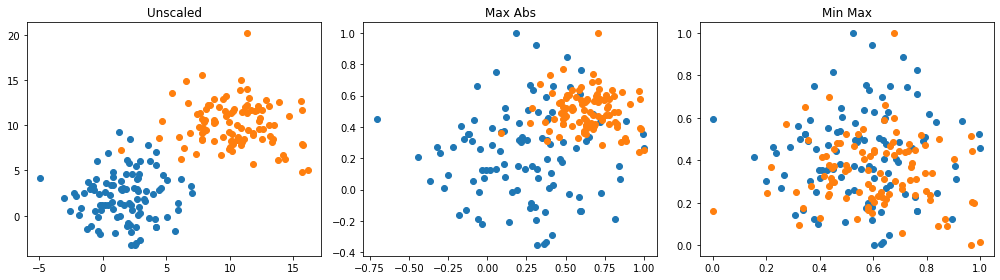

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MaxAbsScaler, minmax_scale

# for reproducibility
np.random.seed(42) 

# unscaled
std = 7
X = np.random.multivariate_normal([2, 2], [[std, 0], [0, std]], size=100)
Y = np.random.multivariate_normal([10, 10], [[std, 0], [0, std]], size=100)

# scaler 1
scaler_ = MaxAbsScaler()
X_maxabs = scaler_.fit_transform(X)
Y_maxabs = scaler_.fit_transform(Y)

# scaler 2
X_norm = minmax_scale(X, feature_range=(0, 1), axis=0, copy=True)
Y_norm = minmax_scale(Y, feature_range=(0, 1), axis=0, copy=True)

# plots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))

axes[0].scatter(X[:, 0], X[:, 1])
axes[0].scatter(Y[:, 0], Y[:, 1])
axes[1].scatter(X_maxabs[:, 0], X_maxabs[:, 1])
axes[1].scatter(Y_maxabs[:, 0], Y_maxabs[:, 1])
axes[2].scatter(X_norm[:, 0], X_norm[:, 1])
axes[2].scatter(Y_norm[:, 0], Y_norm[:, 1])
axes[0].title.set_text('Unscaled')
axes[1].title.set_text('Max Abs')
axes[2].title.set_text('Min Max')

fig.tight_layout()

# Singular Vector Decomposition

---


### Setup

In [3]:
import os
import time
import json

import numpy as np
import pandas as pd

from datetime import datetime

start_time = time.time()
dt_object = datetime.fromtimestamp(time.time())
day, T = str(dt_object).split('.')[0].split(' ')
print('Revised on: ' + day)

Revised on: 2021-01-13


### Load Data

In [4]:
def load_data(data):
    raw_path = os.path.join("data","1_raw")
    filename = ''.join([data, ".csv"])
    out_dfm = pd.read_csv(os.path.join(raw_path, filename))
    out_arr = np.array(out_dfm.iloc[:,0].ravel())
    return out_arr

X_train = load_data("X_train")
y_train = load_data("y_train")

# transform y_array into int type
y_train[y_train=='ham'] = 0
y_train[y_train=='spam'] = 1
y_train = y_train.astype('int')

### BoW and Tfidf

Here I clean and preprocess the data in two formats, a Bag-of-upto-Trigrams with 2,000 terms, and a Tfidf representation of the same.

In [5]:
import urlextract
from nltk.stem import WordNetLemmatizer

with open("contractions_map.json") as f:
    contractions_map = json.load(f)

url_extractor = urlextract.URLExtract()
lemmatizer = WordNetLemmatizer()

import custom.clean_preprocess as cp

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

pipe = Pipeline([('counter', cp.DocumentToNgramCounterTransformer(n_grams=3)),
                 ('bot', cp.WordCounterToVectorTransformer(vocabulary_size=2000)),
                 ('tfidf', TfidfTransformer(sublinear_tf=True))          
                ])

In [6]:
# Bag-of-Trigrams
X_trans_counter = pipe['counter'].fit_transform(X_train)
X_trans_bot = pipe['bot'].fit_transform(X_trans_counter)

# Tfidf
X_trans_tfidf = pipe.fit_transform(X_train)

### SVD


In [7]:
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import svd_flip
from sklearn.preprocessing import MaxAbsScaler, minmax_scale

def perform_SVD(X, n_components=300):

    # transpose to a term-document matrix
    U, Sigma, VT = svds(X.asfptype().T, 
                        k=n_components)
    # reverse outputs
    Sigma = Sigma[::-1]
    U, VT = svd_flip(U[:, ::-1], VT[::-1])
    
    # transpose to get V
    V = VT.T
    
    # max abs scales so that the max val is 1
    # includes negative values though
    scaler = MaxAbsScaler()
    X_maxabs = scaler.fit_transform(V) 
    # min max scale fits the data between two vals, 0 and 1 in this case
    X_minmax = minmax_scale(V, feature_range=(0, 1), axis=0, copy=True)
    
    return V, X_maxabs, X_minmax

In [8]:
X_svd, X_maxabs, X_minmax = perform_SVD(X_trans_tfidf)

We end up with matrices that are 3,900 long and 300 wide:

In [9]:
X_svd.shape

(3900, 300)

## Scatter plot of first couple features

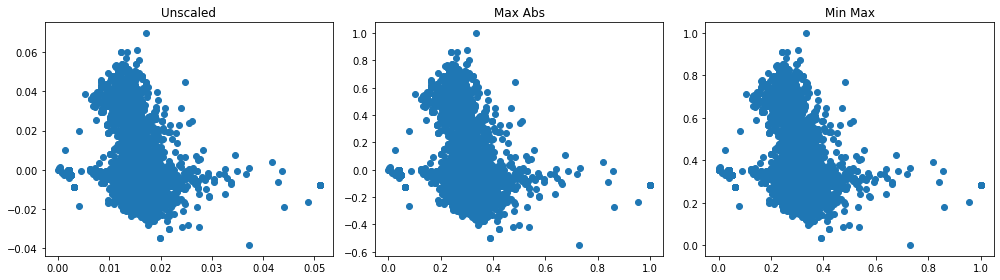

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))

axes[0].scatter(X_svd[:, 0:1], X_svd[:, 1:2])
axes[1].scatter(X_maxabs[:,0:1], X_maxabs[:,1:2])
axes[2].scatter(X_minmax[:,0:1], X_minmax[:,1:2])
axes[0].title.set_text('Unscaled')
axes[1].title.set_text('Max Abs')
axes[2].title.set_text('Min Max')

fig.tight_layout()

---